In [27]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import pickle
import matplotlib.pyplot as plt
import warnings
from keras.preprocessing.image import load_img

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split;

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.optimizers import Adam 


In [28]:
! pip install piexif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# delete the files that have different extension

for root, folders, files in os.walk("/content/drive/MyDrive/proje/PetImages"):
  for folder in folders:
    for _, _, files in os.walk(os.path.join(root, folder)):
      for file in files:
        image_path = os.path.join(root, folder, file)
         #print(image_path)
        if not image_path.endswith('.jpg'):
         # print(image_path)
          os.remove(image_path)

In [53]:
 # removing the corrupted files

import PIL
from pathlib import Path
from PIL import UnidentifiedImageError
from PIL import Image
import piexif


path = Path("/content/drive/MyDrive/proje/PetImages").rglob("*.jpg")
for image_path in path:
    
    try:
        imgage = Image.open(image_path)
        exif_data = image._getexif()
    except ValueError as err:
        print(err)
        print("Error on image: ", image)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

In [54]:
image_size = (100, 100)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/proje/PetImages",
    validation_split=0.2,
    subset="training",
    label_mode="int",
    labels="inferred",
    seed=1337,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/proje/PetImages",
    validation_split=0.2,
    label_mode="int",
    labels="inferred",
    subset="validation",
    seed=1337,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
)

Found 13263 files belonging to 2 classes.
Using 10611 files for training.
Found 13263 files belonging to 2 classes.
Using 2652 files for validation.


In [32]:
val_ds.class_names

['Cat', 'Dog']

In [55]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


In [56]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

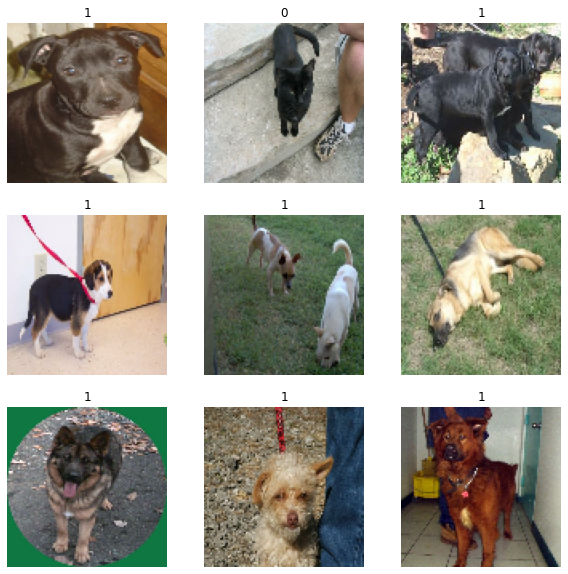

In [57]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [59]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [60]:
for image, label in tfds.as_numpy(train_ds):
  print(type(image), type(label), label)
  break

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [61]:
for image, label in tfds.as_numpy(val_ds):
  print(type(image), type(label), label)
  break

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1]


In [63]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

data_augmentation = keras.Sequential(
    [
        Rescaling(1./255),
        RandomFlip("horizontal"),
        RandomFlip("vertical"),
        RandomRotation(0.1),
        RandomZoom(0.15),
    ]
)

In [64]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D , Flatten ,Dense, Dropout

model=Sequential([
    data_augmentation,
    Conv2D(32,(3,3), activation="relu", input_shape=(180,180,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])


In [65]:
model.compile(
    optimizer=keras.optimizers.SGD(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [66]:
model.fit(
  train_ds,
  batch_size=batch_size,
  epochs=10,
  validation_data=val_ds,
  shuffle=True
)

Epoch 1/10
200/200 [==============================] - 111s 542ms/step - loss: 0.2549 - accuracy: 0.9425 - val_loss: 0.2337 - val_accuracy: 0.9388
Epoch 2/10
200/200 [==============================] - 105s 524ms/step - loss: 0.2245 - accuracy: 0.9441 - val_loss: 0.2253 - val_accuracy: 0.9413
Epoch 3/10
200/200 [==============================] - 106s 528ms/step - loss: 0.2243 - accuracy: 0.9441 - val_loss: 0.2226 - val_accuracy: 0.9438
Epoch 4/10
200/200 [==============================] - 107s 530ms/step - loss: 0.2247 - accuracy: 0.9439 - val_loss: 0.2303 - val_accuracy: 0.9400
Epoch 5/10
200/200 [==============================] - 111s 550ms/step - loss: 0.2256 - accuracy: 0.9431 - val_loss: 0.2245 - val_accuracy: 0.9425
Epoch 6/10
200/200 [==============================] - 112s 555ms/step - loss: 0.2234 - accuracy: 0.9444 - val_loss: 0.2236 - val_accuracy: 0.9438
Epoch 7/10
200/200 [==============================] - 110s 545ms/step - loss: 0.2226 - accuracy: 0.9441 - val_loss: 0.2223 -

In [66]:
preds = model.predict(val_ds.take(32))
preds.shape

(800, 1)

In [ ]:
preds = [ 1 if i >= 0.5 else 0 for i in preds]
preds